In [53]:
suppressMessages({
    library(Rssa)
    library(ixp)
    library(xts)
    library(ggplot2)
    library(viridis)
    library(knitr)
    library(IRdisplay)
})

In [54]:
plot.wcor <- function(w, pallete="viridis") {
    stopifnot(pallete %in% c("viridis", "magma", "plasma", "inferno", "cividis"))
    my_melt <- function(x) {
      row_names <- rep(rownames(x), ncol(x))
      col_names <- unlist(lapply(colnames(x), function(cn) rep(cn, nrow(x))))
      melt_vals <- as.vector(x) # R does this in column order.
      data.frame(row=row_names, col=col_names, val=melt_vals)
    }              
    w <- my_melt(w)
    groups <- 1:nrow(w)
    g <- ggplot(w, aes(x=factor(row, levels=paste0("F", groups)), 
                       y=factor(col, levels=paste0("F", groups))))
    g <- g + geom_tile(aes(fill=val), colour="#000000", size=0.1, show.legend=F)
    g <- g + scale_fill_viridis(option=pallete)
    g + theme(axis.text.x = element_text(angle = 90, hjust = 1))
}

In [55]:
plot.eigenvectors <- function(s, group, zoom=288*7, ncols=4) {
    len <- length(group)
    # visualise reconstructed or original eigenvectos?
    series <- s$U
    # cut 1 month from end+start: ssa quality deteriorates at edges
    series <- head(series, -(288*30))
    series <- tail(series, -(288*30))
    if(zoom > 0) series <- head(series, zoom)
    nrows <- ceiling(len / ncols)
    par(mfrow=c(nrows, ncols), mar=c(0.1, 0.1, 0.1, 0.1))
    for(i in 1:len) plot(series[, i], type="l", xaxt="n", yaxt="n", bty="n")
}

In [56]:
plot.reconstructed <- function(s, group, zoom=288*7, ncols=4) {
    len <- length(group)
    # visualise reconstructed or original eigenvectos?
    series <- reconstruct(s)
    nrows <- ceiling(len / ncols)
    par(mfrow=c(nrows, ncols), mar=c(0.1, 0.1, 0.1, 0.1))
    for(i in group) { 
        # cut 1 month from end+start: ssa quality deteriorates at edges
        x <- head(series[[i]], -(288*30))
        x <- tail(x, -(288*30))
        if(zoom > 0) x <- head(x, zoom)
        plot(x, type="l", xaxt="n", yaxt="n", bty="n")
    }
}

In [57]:
plot.component.norms <- function(s, lim) {
    sigma <- s$sigma
    sigma <- sigma/sum(sigma)
    if(!missing(lim)) sigma <- head(sigma, lim)
    plot(sigma, type="l", xaxt = "n")
    axis(1, 1:length(sigma))
}

In [72]:
to.xts <- function(v) xts(v, order.by=power$date)

In [59]:
xts.reconstruct <- function(s, groups) {
    r <- reconstruct(s, groups)
    to.xts(do.call("cbind", r))
}

In [60]:
linear_interpolate <- function(x, interval="5 min", ...) {
    max_diff <- max(diff(index(x)))
    if(as.numeric(max_diff) > 60*12) {
        warning(paste("ts has gap > 12 hours:", max_diff, "could not interpolate!"))
        return(x)
    }
    xx <- na.approx(x, xout=seq(min(index(x)), max(index(x)), by=interval, ...))
    stopifnot(sum(as.numeric(abs(diff(abs(diff(index(xx))))))) == 0)
    xx
}

In [43]:
a <- read.csv("../data/power/DemandData_2011-2016.csv", stringsAsFactor=F)
b <- read.csv("../data/power/DemandData_2017.csv", stringsAsFactor=F)
c <- read.csv("../data/power/DemandData_2018.csv", stringsAsFactor=F)

In [44]:
a$date <- as.Date(toupper(a$SETTLEMENT_DATE), format = "%d-%b-%Y", tz="UTC", origin="1970-01-01")
a <- a[a$date >= "2016-01-01", ]
head(a)

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,I014_ND,TSD,I014_TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,⋯,FRENCH_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,I014_FRENCH_FLOW,I014_BRITNED_FLOW,I014_MOYLE_FLOW,I014_EAST_WEST_FLOW,I014_TSD.1,date
87649,01-Jan-2016,1,27700,27664,28414,28299,25315,1294,4013,0,⋯,1756,870,31,105,1740,872,25,103,NA,2016-01-01
87650,01-Jan-2016,2,28379,28278,29007,28904,26025,1230,4013,0,⋯,1755,881,19,27,1740,883,25,26,NA,2016-01-01
87651,01-Jan-2016,3,28155,27986,29063,29097,25804,1148,4013,0,⋯,1755,871,76,36,1740,875,76,36,NA,2016-01-01
87652,01-Jan-2016,4,27147,26961,28326,28149,24867,1065,4013,0,⋯,1756,887,-7,65,1740,888,-14,65,NA,2016-01-01
87653,01-Jan-2016,5,26154,26006,27348,27283,23993,1004,4013,0,⋯,1756,880,-101,20,1740,883,-100,20,NA,2016-01-01
87654,01-Jan-2016,6,25635,25463,26737,26723,23441,943,4013,0,⋯,1756,867,-63,4,1740,867,-63,1,NA,2016-01-01


In [45]:
b$date <- as.Date(toupper(b$SETTLEMENT_DATE), format = "%d-%b-%Y", tz="UTC", origin="1970-01-01")
head(b)

SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,I014_ND,TSD,I014_TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,⋯,I014_PUMP_STORAGE_PUMPING,FRENCH_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,I014_FRENCH_FLOW,I014_BRITNED_FLOW,I014_MOYLE_FLOW,I014_EAST_WEST_FLOW,date
01-JAN-2017,1,27316,27117,28013,27833,24789,1514,4871,0,⋯,117,923,857,295,233,947,857,296,240,2017-01-01
01-JAN-2017,2,27900,27706,28539,28329,25486,1518,4871,0,⋯,20,997,874,297,287,986,874,297,286,2017-01-01
01-JAN-2017,3,27588,27286,28279,27916,25254,1543,4871,0,⋯,125,997,818,297,287,986,816,297,286,2017-01-01
01-JAN-2017,4,26456,26169,27819,27550,24270,1567,4871,0,⋯,806,997,822,297,287,986,828,297,287,2017-01-01
01-JAN-2017,5,25429,25150,27565,27316,23409,1601,4871,0,⋯,1566,997,854,297,281,986,855,297,281,2017-01-01
01-JAN-2017,6,24754,24528,26738,26550,22785,1634,4871,0,⋯,1380,998,853,297,287,986,855,297,286,2017-01-01


In [46]:
c$date <- as.Date(toupper(c$SETTLEMENT_DATE), format = "%d-%b-%Y", tz="UTC", origin="1970-01-01")
tail(c)

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,I014_ND,TSD,I014_TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,⋯,I014_PUMP_STORAGE_PUMPING,FRENCH_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,I014_FRENCH_FLOW,I014_BRITNED_FLOW,I014_MOYLE_FLOW,I014_EAST_WEST_FLOW,date
17515,31-DEC-2018,43,28020,26493,29590,27106,26303,2092,5918,0,⋯,13,1949,862,-424,-536,1922,869,-422,-530,2018-12-31
17516,31-DEC-2018,44,26826,25359,28428,25975,25195,2111,5918,0,⋯,16,1960,777,-454,-535,1922,744,-453,-530,2018-12-31
17517,31-DEC-2018,45,25660,24242,27542,25161,24145,2131,5918,0,⋯,18,1182,-268,-455,-536,1150,-283,-453,-530,2018-12-31
17518,31-DEC-2018,46,25047,23669,26971,24589,23496,2150,5918,0,⋯,42,1157,-297,-455,-536,1151,-298,-453,-530,2018-12-31
17519,31-DEC-2018,47,24188,22862,26224,23994,22683,2128,5918,0,⋯,41,1546,-467,-454,-466,1533,-473,-453,-456,2018-12-31
17520,31-DEC-2018,48,23800,22494,25785,23620,22367,2106,5918,0,⋯,101,1553,-453,-454,-381,1533,-436,-453,-375,2018-12-31


In [47]:
power <- rbind(a[, c("date", "SETTLEMENT_PERIOD", "ENGLAND_WALES_DEMAND") ],
               b[, c("date", "SETTLEMENT_PERIOD", "ENGLAND_WALES_DEMAND") ],
               c[, c("date", "SETTLEMENT_PERIOD", "ENGLAND_WALES_DEMAND") ])

In [88]:
#power <- power[power$date <= "2018-10-31", ]
power$date <- seq(as.POSIXct("2016-01-01 00:30:00", tz="UTC"), as.POSIXct("2019-01-01 00:00:00", tz="UTC"), by="30 min")
range(power$date)

[1] "2016-01-01 00:30:00 UTC" "2019-01-01 00:00:00 UTC"

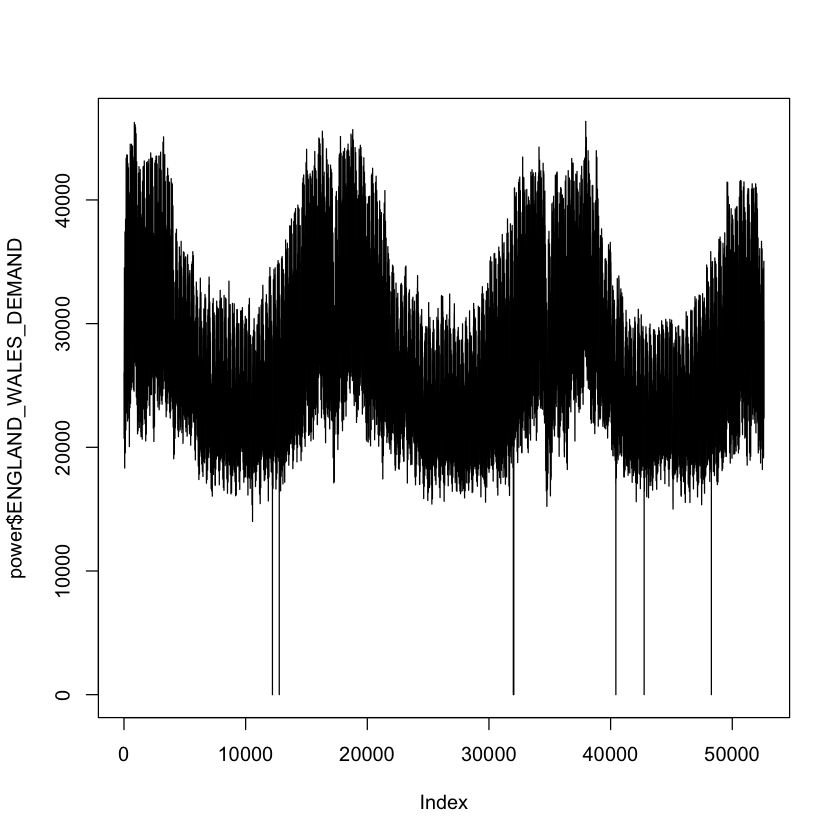

In [49]:
plot(power$ENGLAND_WALES_DEMAND, type="l")

In [51]:
library(Rssa)

Loading required package: svd
Loading required package: forecast

Attaching package: ‘Rssa’

The following object is masked from ‘package:stats’:

    decompose



In [52]:
s <- ssa(power$ENGLAND_WALES_DEMAND)
summary(s)


Call:
ssa(x = power$ENGLAND_WALES_DEMAND)

Series length: 52608,	Window length: 26304,	SVD method: nutrlan
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 10.24 MiB


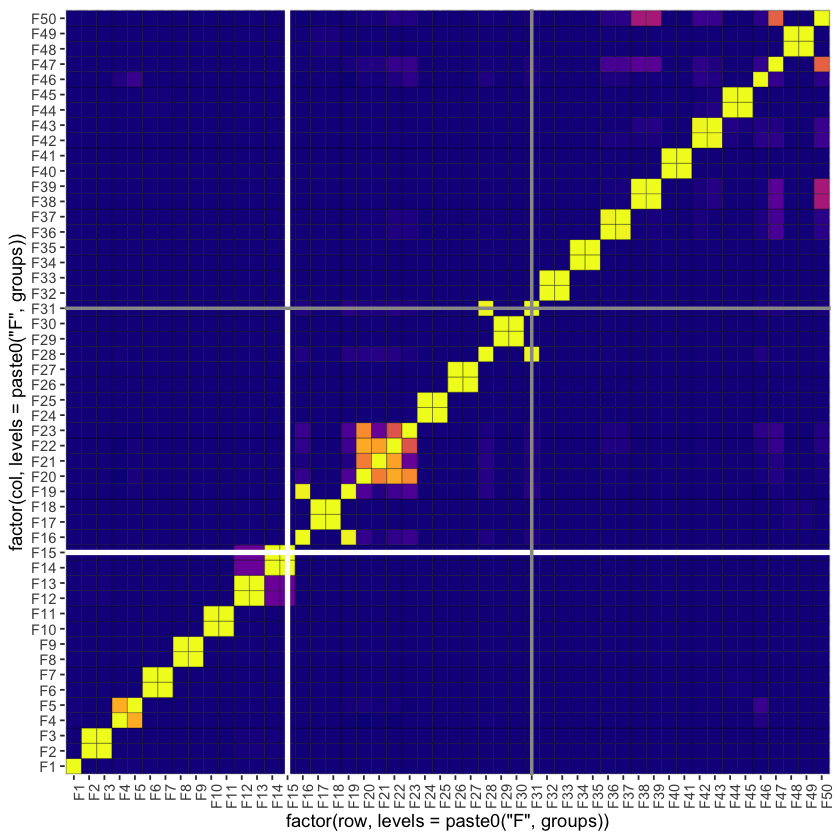

In [61]:
w <- wcor(s, groups = as.list(1:50))
g <- plot.wcor(w, "plasma")
g <- g + geom_vline(xintercept=15, color="#ffffff", size=1.5)
g <- g + geom_hline(yintercept=15, color="#ffffff", size=1.5)
g <- g + geom_vline(xintercept=31, color="#999999", size=1)
g + geom_hline(yintercept=31, color="#999999", size=1)

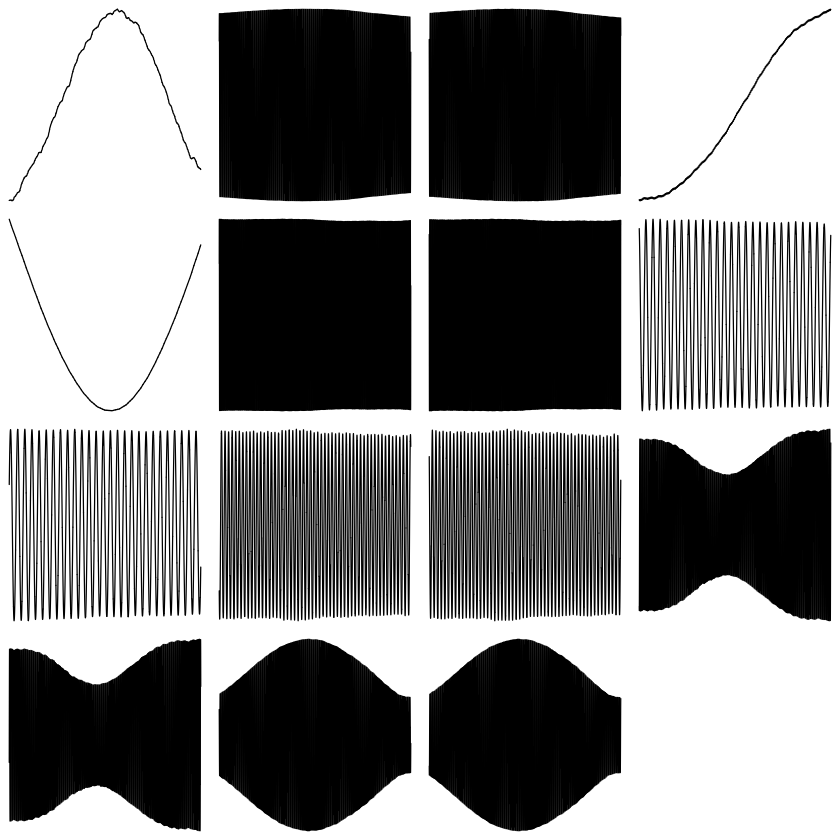

In [64]:
plot.eigenvectors(s, group=1:11, zoom=0)

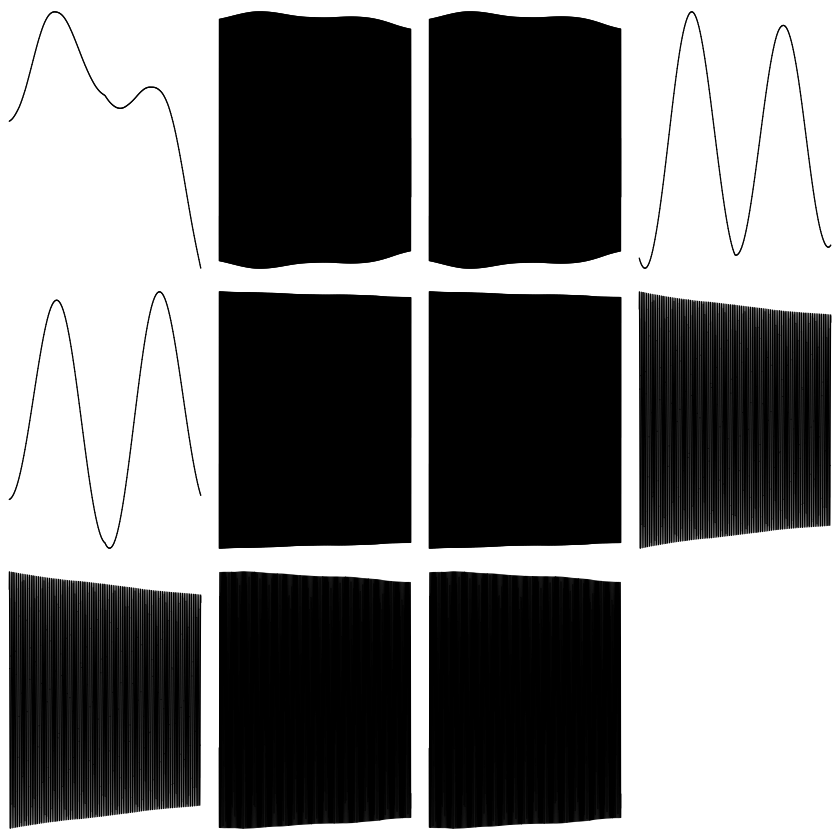

In [78]:
plot.reconstructed(s, group=1:11, zoom=0)

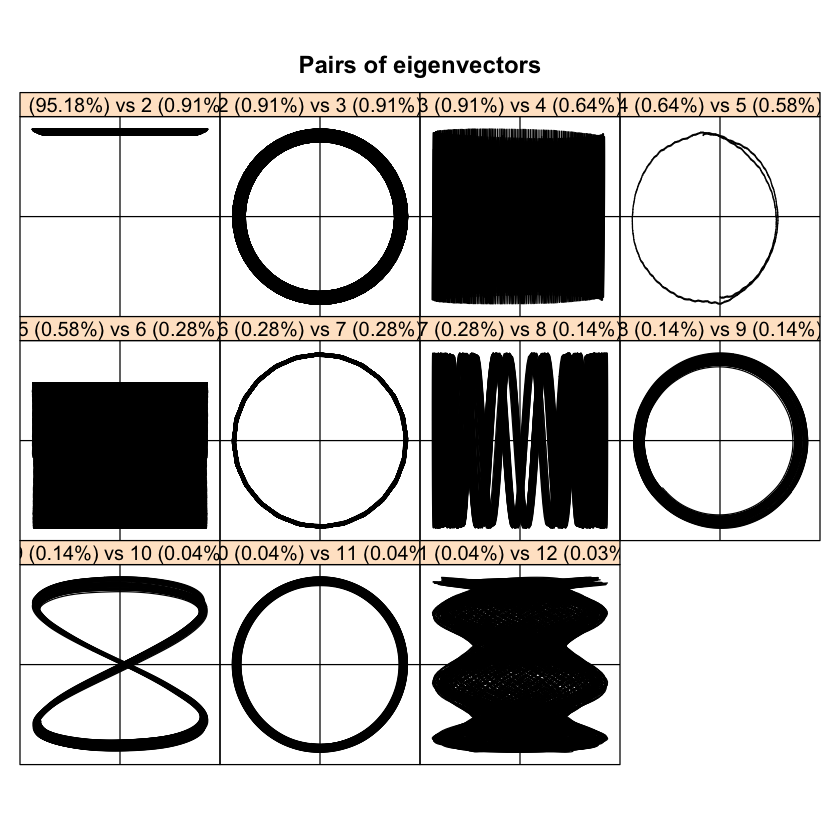

In [79]:
plot(s, type="paired", col="black", idx=1:11)

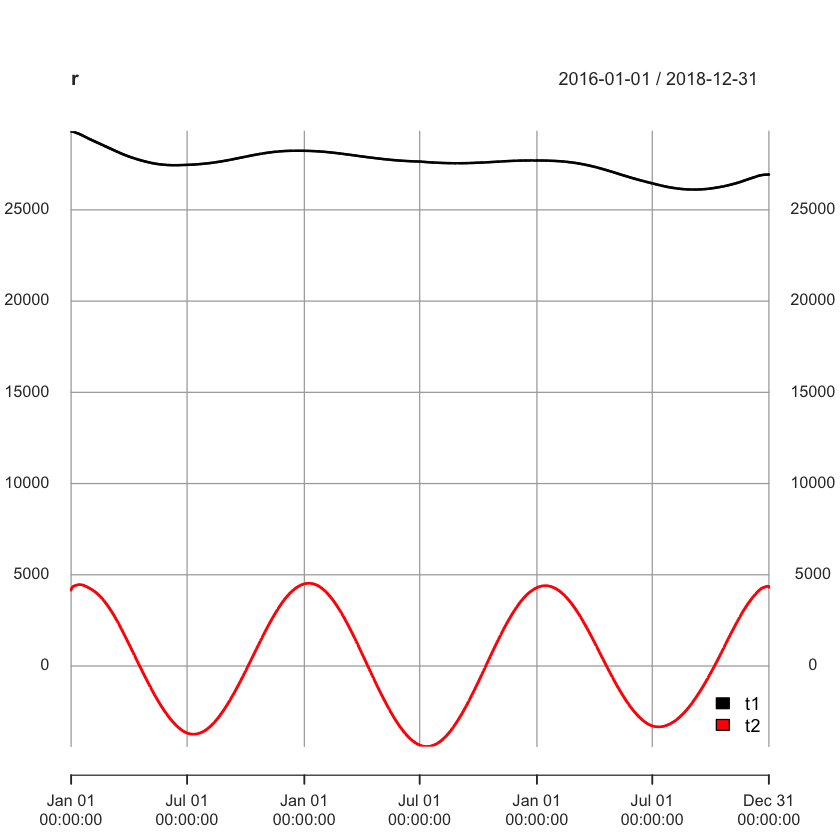

In [76]:
r <- xts.reconstruct(s, list(t1=1, t2=c(4,5)))
plot(r, legend.loc="bottomright")

In [96]:
groups <- list(t1=1, t2=c(4, 5), c1=c(2, 3), c2=c(6, 7), c3=c(8, 9), c4=c(10, 11), c5=c(12,13,14,15))
r <- xts.reconstruct(s, groups)
r.raw <- reconstruct(s, groups)
r$orig <- power$ENGLAND_WALES_DEMAND

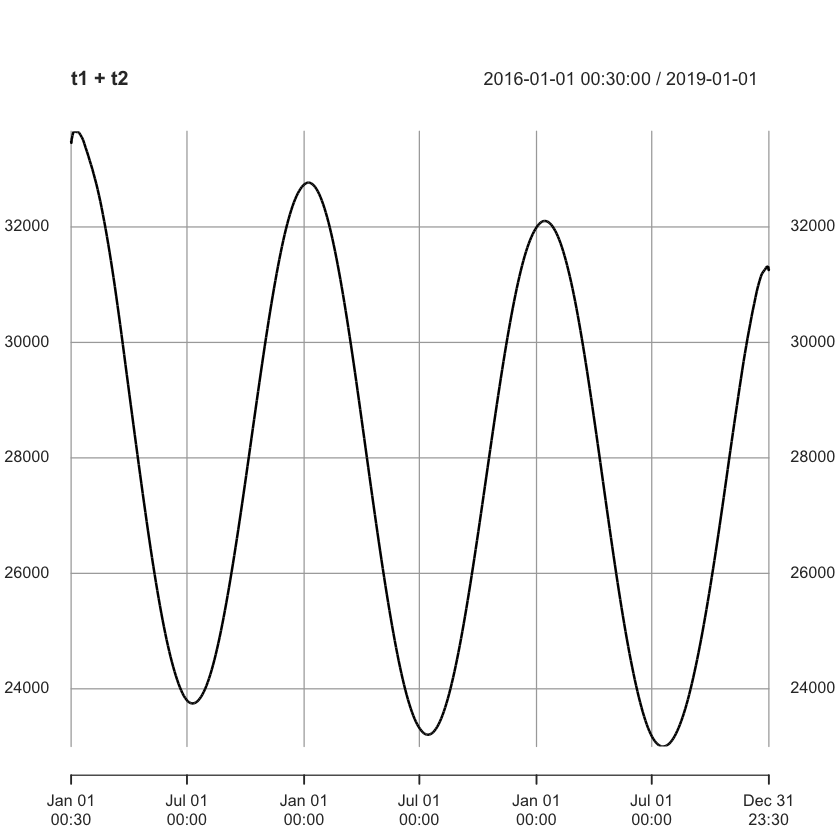

In [90]:
with(r, plot(t1+t2))

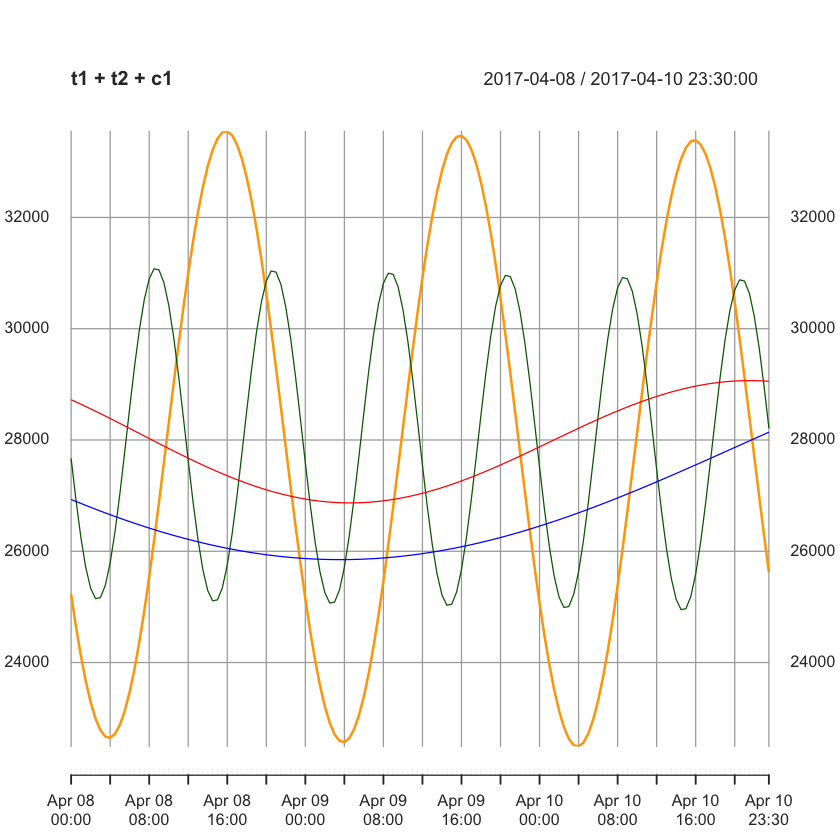

In [120]:
with(r["2017-04-08/2017-04-10"], { # sun : mon
    plot( t1+t2+c1, col="orange") 
    lines(t1+t2+c2, col="darkgreen")
    lines(t1+t2+c3, col="blue")
    lines(t1+t2+c4, col="red")
    #lines(t1+t2+c5, col="purple")
})  

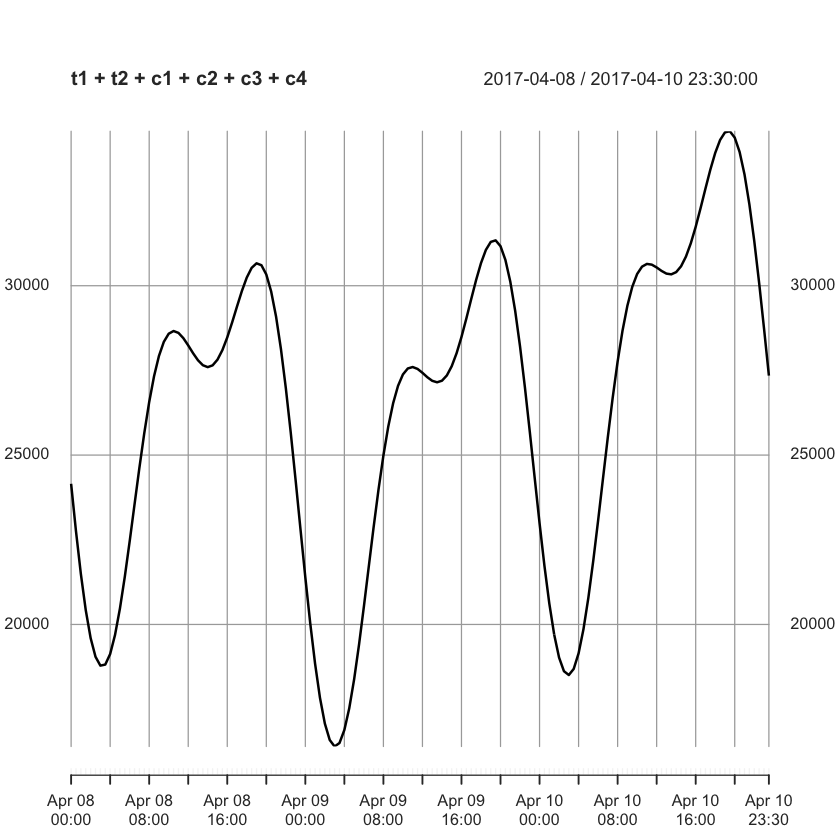

In [121]:
with(r["2017-04-08/2017-04-10"], { # sun : mon
    plot(t1+t2+c1+c2+c3+c4)
})  

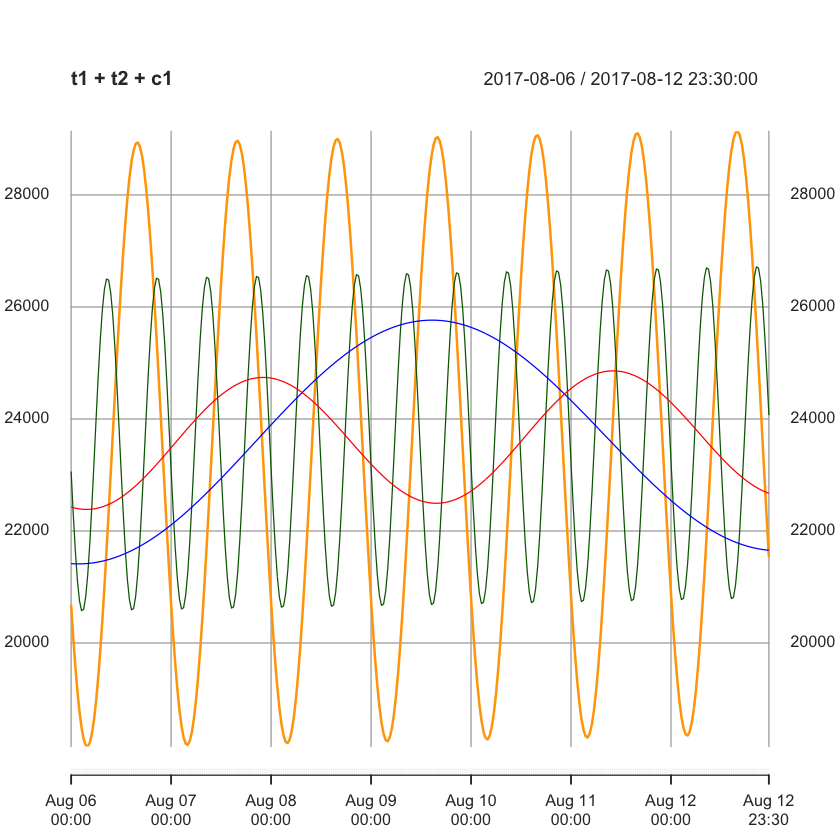

In [122]:
with(r["2017-08-06/2017-08-12"], {
    plot( t1+t2+c1, col="orange") 
    lines(t1+t2+c2, col="darkgreen")
    lines(t1+t2+c3, col="blue")
    lines(t1+t2+c4, col="red")
})

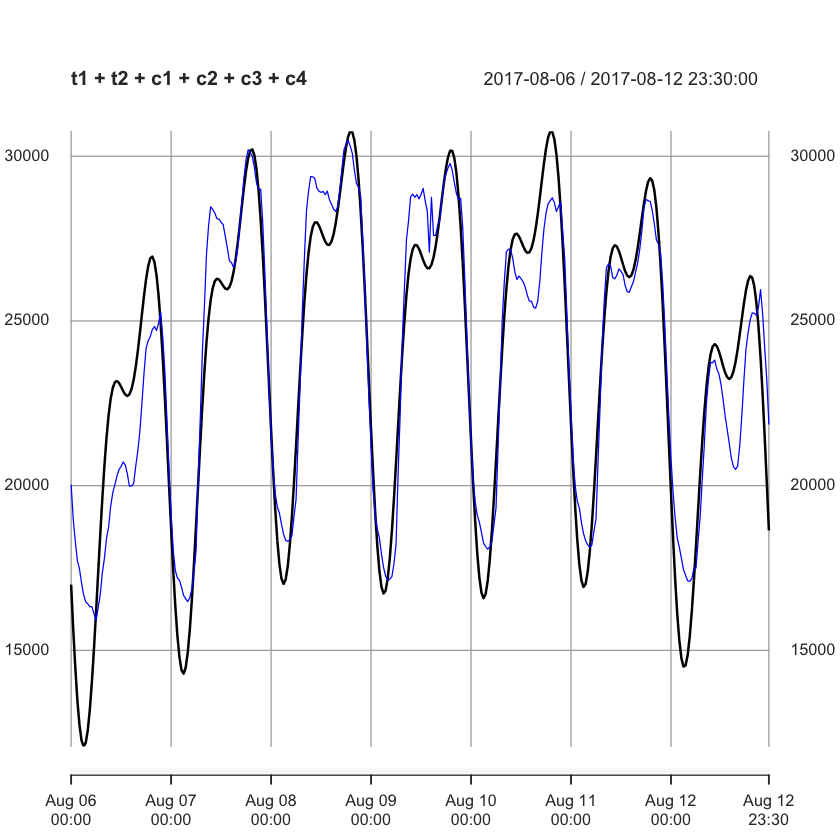

In [133]:
with(r["2017-08-06/2017-08-12"], {
    plot(t1+t2+c1+c2+c3+c4)
    lines(orig, col="blue")
})

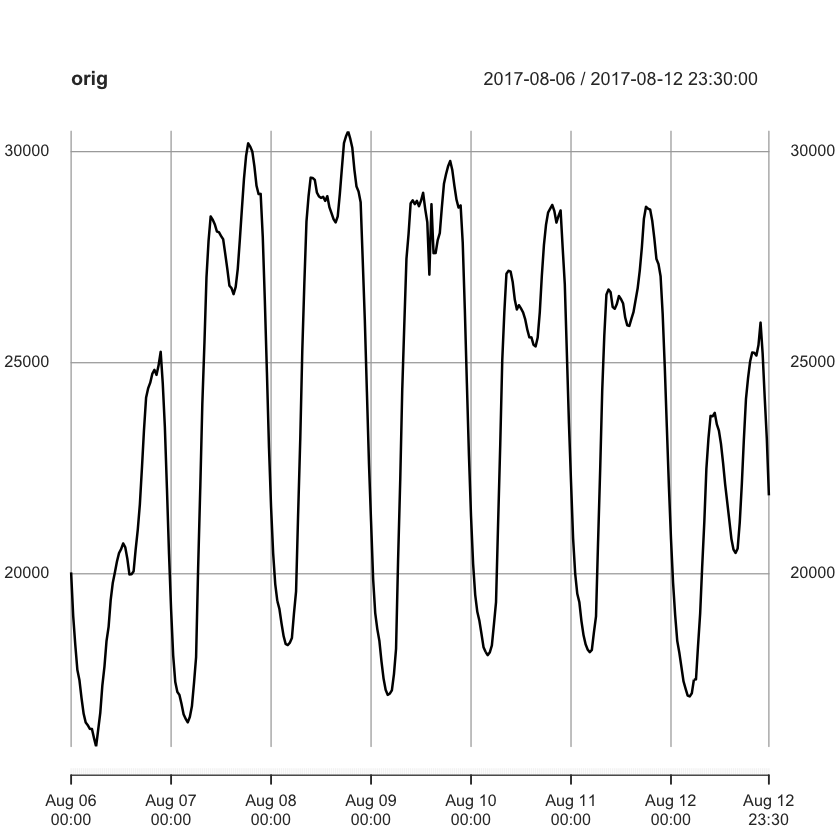

In [111]:
with(r["2017-08-06/2017-08-12"], {
    plot(orig)
})

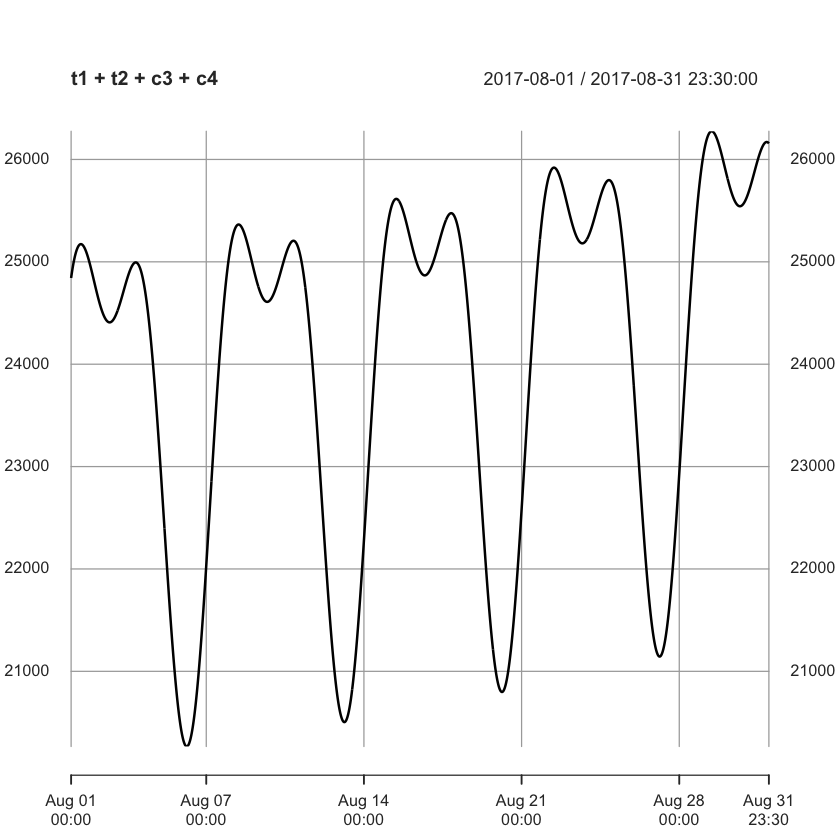

In [124]:
with(r["2017-08-01/2017-08-31"], {
    plot(t1+t2+c3+c4)
})

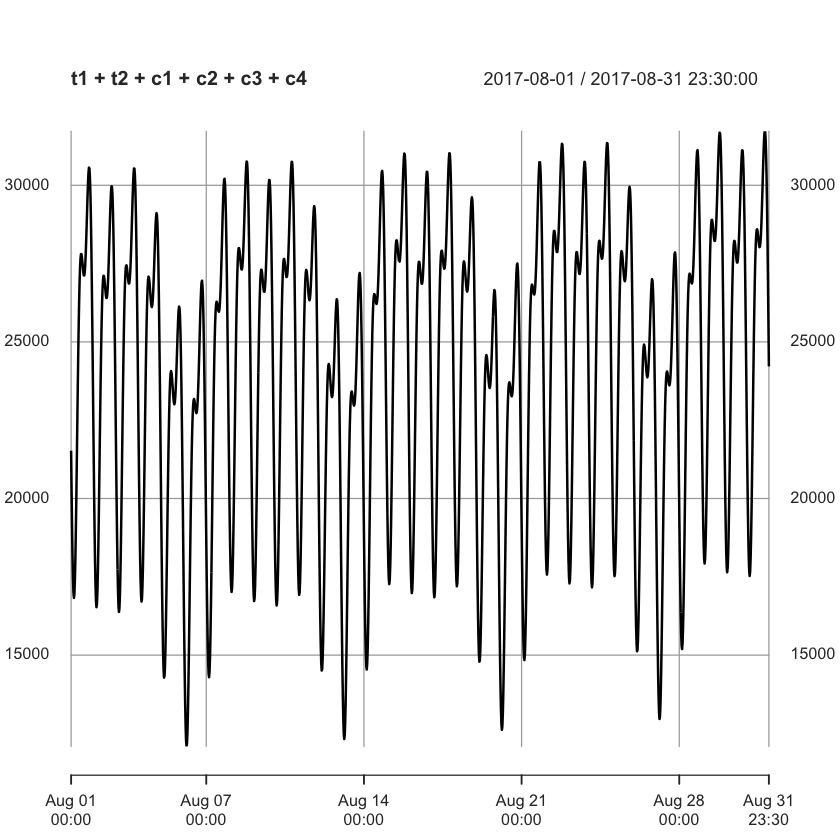

In [131]:
with(r["2017-08-01/2017-08-31"], {
    plot(t1+t2+c1+c2+c3+c4)
})

In [135]:
power$sa <- power$ENGLAND_WALES_DEMAND - (r.raw$t1 + r.raw$t2 + r.raw$c3 + r.raw$c4)
power$model <- with(r.raw, t1+t2+c1+c2+c3+c4)
power$trend <- r.raw$t1
power$winter_summer <- r.raw$t2
power$inter_week <- r.raw$c3 + r.raw$c4
power$daily <- r.raw$c1 + r.raw$c2

In [136]:
head(power)

,date,SETTLEMENT_PERIOD,ENGLAND_WALES_DEMAND,sa,model,trend,winter_summer,inter_week,daily
87649,2016-01-01 00:30:00,1,25315,-9886.860,30325.22,29308.56,4181.279,1712.018,-4876.642
87650,2016-01-01 01:00:00,2,26025,-9156.529,29082.44,29308.38,4179.412,1693.738,-6099.085
87651,2016-01-01 01:30:00,3,25804,-9355.099,28036.97,29308.16,4177.407,1673.534,-7122.127
87652,2016-01-01 02:00:00,4,24867,-10267.717,27235.16,29307.92,4175.304,1651.492,-7899.555
87653,2016-01-01 02:30:00,5,23993,-11115.549,26710.71,29307.69,4173.146,1627.717,-8397.838
87654,2016-01-01 03:00:00,6,23441,-11639.712,26482.61,29307.46,4170.960,1602.294,-8598.097


In [138]:
write.csv(power, "power_sa_2016-2018.csv", row.names=F, quote=F)